# A Customer Retention Strategy for the Gym Chain 'Model Fitness'

The gym chain 'Model Fitness' has digitized a number of its customer profiles and provided a CSV file containing data on churn for a given month and information on the month preceding it. The goal of this project is to analyze them and to come up with a customer retention strategy. <br> <br>
More precisely we will predict the churn for the upcoming month for customers, select the most outstanding groups of customers, give a description of their main features and analyze the factors that impact customer churn most. At the end of the project I develop recommendations on how to improve customer service and will suggest measures to cut churn.

# Table of Contents

- 1) [Open the Data and Study the General Information](#1)
    <br> <br>
- 2) [Exploratory Data Analysis](#2)
<br> <br>
    - 2.1) [Values of the features](#2.1)
    - 2.2) [Mean values and standard deviations](#2.2)
    - 2.3) [Mean values by churn status](#2.3)
    - 2.4) [Distributions of the features by churn status](#2.4)
    - 2.5) [Correlation matrix](#2.5)
    <br> <br>
- 3) [Build a Model to Predict Customer Churn](#3)
<br> <br>    
- 4) [Create Customer Clusters](#4)
<br> <br>      
    - 4.1) [Estimation of the number of clusters with a dendrogram](#4.1)
    - 4.2) [K-means algorithm and the mean feature values for clusters](#4.2)
    - 4.3) [Distributions of features by cluster](#4.3)
    - 4.4) [Churn rate for each cluster](#4.4)
<br> <br>       
- 5) [Overall Conclusion and Recommendations](#5)

<a id="1"></a>

## 1) Open the Data and Study the General Information

In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
import seaborn as sns
import numpy as np
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [2]:
# read the data file
try:
    df = pd.read_csv('C:/Users/Herbert/Documents/Practicum100/datasets/forecasts_and_predictions_gym_churn_us.csv')
except:
    print("Couldn't read the data file.")

In [3]:
# print head
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
# size of the data
df.shape

(4000, 14)

In [5]:
# rename one certain column
df = df.rename(columns={"Avg_additional_charges_total": "additional_charges_total"})

In [6]:
# info about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
additional_charges_total             4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


### Conclusion

The table 'df' contains customer profiles of the gym chain 'Fitness Model'. It consists of 4000 rows and 14 columns. 4 columns are in float data type and 10 columns are in integer data type; there is no column in object data type. We have no missing value in the whole data set. One column is about churn for a given month:

- 'Churn' — churn is whether the customer did come in the given month or not; 0 means customer stayed (did come at least one time in the month), 1 means customer left

The other columns contain the following information from the preceding month (in general: 1 means Yes/True and 0 means No/False):

- 'gender' — 0 means female, 1 means male
- 'Near_Location' — whether the customer lives or works in the neighborhood where the gym is located
- 'Partner' — whether the customer is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)
- 'Promo_friends' — whether the customer originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)
- 'Phone' — whether the customer provided their phone number
- 'Age' — in years
- 'Lifetime' — the time (in months) since the customer first came to the gym
- 'Contract_period' — 1 month, 6 months, or 1 year of time period in the contract
- 'Month_to_end_contract' — the months remaining until the contract expires
- 'Group_visits' — whether the customer takes part in group sessions
- 'Avg_class_frequency_total' — average frequency of visits per week over the customer's lifetime
- 'Avg_class_frequency_current_month' — average frequency of visits per week over the preceding month
- 'additional_charges_total' — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc. in Dollars

In terms of machine learning, we have 4000 observations and 14 fields, so we have 286 times more observations than fields; that means the number of observations is sufficient. Every observation stands for one customer with its fields.

<a id="2"></a>

## 2) Exploratory Data Analysis

<a id="2.1"></a>

### 2.1) Values of the features

In [7]:
# display the unique values for those features with very limited expected number of values
columns_limited = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Contract_period', 'Group_visits', 'Churn']

for col in columns_limited:
    print(col)
    print(df[col].unique())

gender
[1 0]
Near_Location
[1 0]
Partner
[1 0]
Promo_friends
[1 0]
Phone
[0 1]
Contract_period
[ 6 12  1]
Group_visits
[1 0]
Churn
[0 1]


In [8]:
print("Lowest and Highest Age:")
print(df['Age'].min())
print(df['Age'].max())
print("Lowest and Highest Lifetime:")
print(df['Lifetime'].min())
print(df['Lifetime'].max())
print("Lowest and Highest Month_to_end_contract:")
print(df['Month_to_end_contract'].min())
print(df['Month_to_end_contract'].max())
print("Lowest and Highest additional_charges_total:")
print(df['additional_charges_total'].min())
print(df['additional_charges_total'].max())
print("Lowest and Highest Avg_class_frequency_total:")
print(df['Avg_class_frequency_total'].min())
print(df['Avg_class_frequency_total'].max())
print("Lowest and Highest Avg_class_frequency_current_month:")
print(df['Avg_class_frequency_current_month'].min())
print(df['Avg_class_frequency_current_month'].max())

Lowest and Highest Age:
18
41
Lowest and Highest Lifetime:
0
31
Lowest and Highest Month_to_end_contract:
1.0
12.0
Lowest and Highest additional_charges_total:
0.1482047884566242
552.5907403868798
Lowest and Highest Avg_class_frequency_total:
0.0
6.02366847599591
Lowest and Highest Avg_class_frequency_current_month:
0.0
6.146782880452392


In [9]:
# count values for Month_to_end_contract
df['Month_to_end_contract'].value_counts()

1.0     2207
6.0      645
12.0     524
11.0     181
5.0      130
10.0      82
9.0       73
4.0       58
8.0       38
7.0       25
3.0       23
2.0       14
Name: Month_to_end_contract, dtype: int64

In [10]:
# transform the column into integer data type
try:
    df['Month_to_end_contract'] = df['Month_to_end_contract'].astype('int')
except:
    print("Couldn't transform column 'Month_to_end_contract' into integer data type.")

In [11]:
# look for the number of duplicates
len(df[df.duplicated() == True])

0

#### Conclusion

The features having the values 0 and 1 don't have any unexpected other values. Also the feature 'Contract_period' only consists of the values 1, 6 and 12 months. The minima and maxima of the other features are all within ordinary ranges, so there's no need to delete any data that is wrong (like negative numbers). Since all numbers in the column 'Month_to_end_contract' are integers I transformed that column into that type. The data doesn't have any duplicates or missing values.

<a id="2.2"></a>

### 2.2) Mean values and standard deviations

In [12]:
# display mean values and standard deviations for every feature
df.describe().loc[['mean','std']]

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521


In [13]:
# number of new customers (lifetime 0 months)
len(df[df['Lifetime'] == 0])

487

#### Conclusion

Looking at the mean values and the standard deviations of the features having only the values 0 and 1, we can divide them into 3 groups:
- Group 1) 'gender' (mean: 0.51, std: 0.50), 'Partner' (mean: 0.49, std: 0.50) and 'Group_visits' (mean: 0.41, std: 0.49). These features have means near 0.5 and very big standard deviations that are also near 0.5.
- Group 2) 'Promo_friends' (mean: 0.31, std: 0.46) and 'Churn' (mean: 0.27, std: 0.44). These features have means that are more far away from 0.5 but standard deviations that are still near 0.5.
- Group 3) 'Near_Location' (mean: 0.85, std: 0.36) and 'Phone' (mean: 0.90, std: 0.30). These features have means and standard deviations that are more far away from 0.5.

From these observations I expect that features in group 1 have approximately a similar number of 0 and 1 values while group 2 shows a bigger difference of value counts for 0 and 1 and group 3 increases that difference. <br> <br> The feature 'Age' (mean: 29.2, std: 3.3) reveals that we mainly have younger customers since the mean is 29 years and the standard deviation is very small. The feature 'Lifetime' (mean: 3.72, std: 3.75) has the value '0 months' within the first standard deviation; that means we have a high number of new customers (487 to be precise). The upper limit of the standard deviation of the lifetime is around 7.5 months, so I expect less customers in the data visiting their gym since years. The mean value of churn is 0.265 which means that the churn rate overall is 26.5% in the data set. The other features have mean values and standard deviations that are inconspicuous.

<a id="2.3"></a>

### 2.3) Mean values by churn status

We look at the mean values when grouping the customers into two groups: Those who stayed (Churn = 0) and those who left (Churn = 1).

In [14]:
# mean feature values by churn status
df.groupby(['Churn']).mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


#### Conclusion

Comparing the difference between both mean values for every feature, one can group the features consisting of the values 0 and 1 into two groups:

- Group 1) 'gender' (churn 0 mean: 0.51, churn 1 mean: 0.51) and 'Phone' (churn 0 mean: 0.90, churn 1 mean: 0.90). These two features show no difference in mean values for different churn status.
- Group 2) 'Near_Location' (churn 0 mean: 0.87, churn 1 mean: 0.77), 'Partner' (churn 0 mean: 0.53, churn 1 mean: 0.36), 'Promo_friends' (churn 0 mean: 0.35, churn 1 mean: 0.18) and 'Group_visits' (churn 0 mean: 0.46, churn 1 mean: 0.27). These four features show differences in mean values between 0.10 and 0.19.

For the four features in group 2 the mean value is higher for those customers who stayed (churn = 0). <br> 
The feature 'Contract_period' reveals that those who stayed (churn = 0) in average have a much longer time period in the contract (5.7 months) compared to those who left (churn = 1, 1.7 months). The lifetime shows a higher value in average for those who stayed (4.7 months) compared to those who left (1 month). Here we can hypothesise that customer who stayed for a very short time will more likely leave the following month. Also the months until the contract expires are more for those who stayed (5.28 months) compared to those who left (1.66 months). This is a hint that the shorter the time span until the contract expires the more likely the customer leaves; it may be possible that the contract renews itself to a 12-month-contract if not terminated and that would be something that some customers don't want to. In average, the customers who stayed are slightly older (30 years) than those who left (27 years). The features showing the additional charges and the average number of visits per week show all higher values for the customers who stayed.

<a id="2.4"></a>

### 2.4) Distributions of the features by churn status

#### gender

In [15]:
# create pivot table with churn status as columns and gender as index
pivot_churn_gender = df.pivot_table(index='gender', columns='Churn', values='Partner', aggfunc='count')

pivot_churn_gender

Churn,0,1
gender,,
0,1440,519
1,1499,542


In [16]:
# rename columns and index
pivot_churn_gender.columns = ['Stayed', 'Left']
pivot_churn_gender.index = ['Female', 'Male']

pivot_churn_gender

,Stayed,Left
Female,1440,519
Male,1499,542


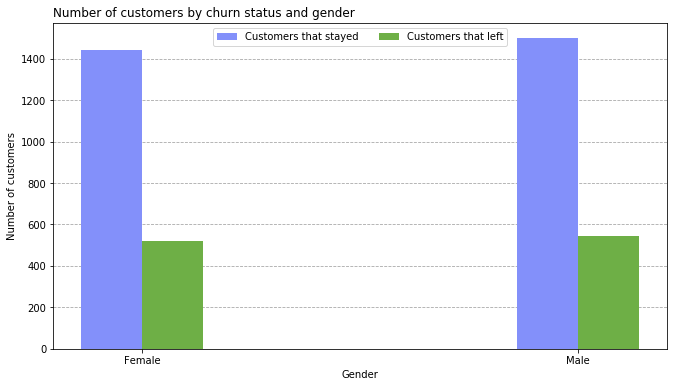

In [17]:
###### Bar chart for 'gender' by churn status

# define figure
fig, ax = plt.subplots(1, figsize=(11, 6))

# numericals
x = np.arange(0, 2)

# plot bars
plt.bar(x - 0.07, pivot_churn_gender['Stayed'], width = 0.14, color = '#8390FA')
plt.bar(x + 0.07, pivot_churn_gender['Left'], width = 0.14, color = '#6EAF46')

# x and y details
plt.ylabel('Number of customers')
plt.xlabel('Gender')
plt.xticks(x, pivot_churn_gender.index)

# grid lines
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.7)

# title and legend
plt.title('Number of customers by churn status and gender', loc ='left')
plt.legend(['Customers that stayed', 'Customers that left'], loc='upper center', ncol = 4)
plt.show()

##### Conclusion

The bar chart above shows the number of customers with certain genders and churn status. For both genders we have around 500 customers that left and around 1450 customers that stayed. Since for both genders the bars have similar heights, the feature 'gender' most likely doesn't influence the churn status.

####  Phone

In [18]:
# create pivot table
pivot_churn_phone = df.pivot_table(index='Phone', columns='Churn', values='Partner', aggfunc='count')
pivot_churn_phone

Churn,0,1
Phone,,
0,283,103
1,2656,958


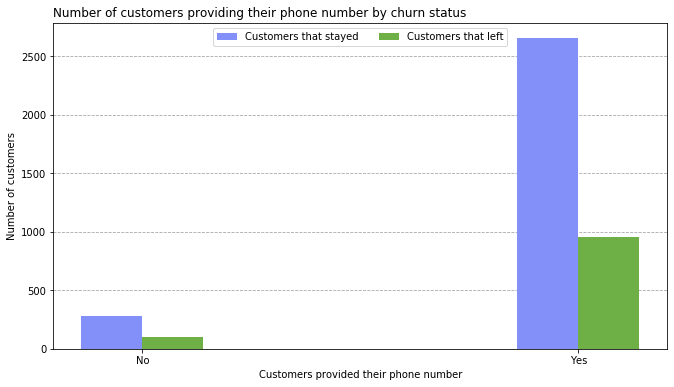

In [19]:
###### Bar chart for 'Phone' by churn status

# rename columns and index of pivot table
pivot_churn_phone.columns = ['Stayed', 'Left']
pivot_churn_phone.index = ['No', 'Yes']

# define figure
fig, ax = plt.subplots(1, figsize=(11, 6))

# numericals
x = np.arange(0, 2)

# plot bars
plt.bar(x - 0.07, pivot_churn_phone['Stayed'], width = 0.14, color = '#8390FA')
plt.bar(x + 0.07, pivot_churn_phone['Left'], width = 0.14, color = '#6EAF46')

# x and y details
plt.ylabel('Number of customers')
plt.xlabel('Customers provided their phone number')
plt.xticks(x, pivot_churn_phone.index)

# grid lines
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.7)

# title and legend
plt.title('Number of customers providing their phone number by churn status', loc ='left')
plt.legend(['Customers that stayed', 'Customers that left'], loc='upper center', ncol = 4)
plt.show()

##### Conclusion

The bar chart above shows the number of customers providing their phone number by churn status. As one can see, there are for both churn statuses more customers that provided their phone number. Since the mean value for both churn statuses was 0.9, 90% of all customers provided their phone number; that can be seen by the relative difference of the green bars for example where the bigger green bar is approximately 9 times higher than the smaller one. The relative difference of the bars within 'Yes' and 'No' are the same: We have approximately 2.5 times more staying customers than leaving customers.

#### Near_Location

In [20]:
# create pivot table
pivot_churn_loc = df.pivot_table(index='Near_Location', columns='Churn', values='Partner', aggfunc='count')
pivot_churn_loc

Churn,0,1
Near_Location,,
0,373,246
1,2566,815


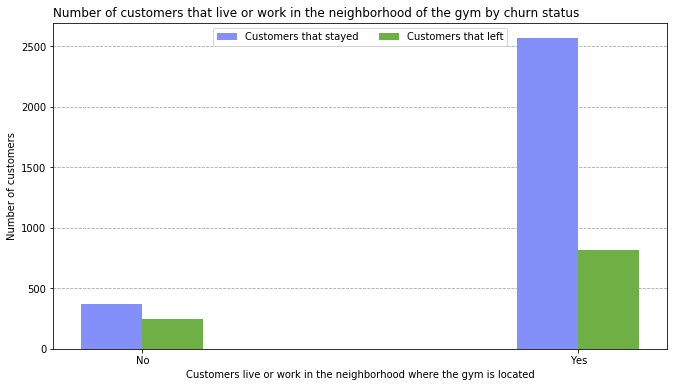

In [21]:
###### Bar chart for 'Near_Location' by churn status

# rename columns and index of pivot table
pivot_churn_loc.columns = ['Stayed', 'Left']
pivot_churn_loc.index = ['No', 'Yes']

# define figure
fig, ax = plt.subplots(1, figsize=(11, 6))

# numericals
x = np.arange(0, 2)

# plot bars
plt.bar(x - 0.07, pivot_churn_loc['Stayed'], width = 0.14, color = '#8390FA')
plt.bar(x + 0.07, pivot_churn_loc['Left'], width = 0.14, color = '#6EAF46')

# x and y details
plt.ylabel('Number of customers')
plt.xlabel('Customers live or work in the neighborhood where the gym is located')
plt.xticks(x, pivot_churn_loc.index)

# grid lines
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.7)

# title and legend
plt.title('Number of customers that live or work in the neighborhood of the gym by churn status', loc ='left')
plt.legend(['Customers that stayed', 'Customers that left'], loc='upper center', ncol = 4)
plt.show()

##### Conclusion

The bar chart shows the distribution of customers living or working in the neighborhood where the gym is located by churn status. As one can see the relative difference between the customers that stayed and left is much smaller for the 'No' group compared to the 'Yes' group. We had a mean value of 0.87 for those who stayed and 0.77 for those who left. That can be seen by the relative difference of the green bars and of the blue bars: The one for the blue bars is bigger than the one for the green bars.

#### Partner

In [22]:
# create pivot table
pivot_churn_partner = df.pivot_table(index='Partner', columns='Churn', values='gender', aggfunc='count')
pivot_churn_partner

Churn,0,1
Partner,,
0,1369,684
1,1570,377


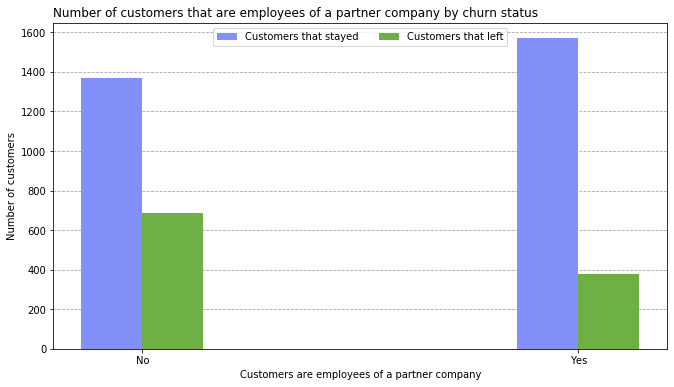

In [23]:
###### Bar chart for 'Partner' by churn status

# rename columns and index of pivot table
pivot_churn_partner.columns = ['Stayed', 'Left']
pivot_churn_partner.index = ['No', 'Yes']

# define figure
fig, ax = plt.subplots(1, figsize=(11, 6))

# numericals
x = np.arange(0, 2)

# plot bars
plt.bar(x - 0.07, pivot_churn_partner['Stayed'], width = 0.14, color = '#8390FA')
plt.bar(x + 0.07, pivot_churn_partner['Left'], width = 0.14, color = '#6EAF46')

# x and y details
plt.ylabel('Number of customers')
plt.xlabel('Customers are employees of a partner company')
plt.xticks(x, pivot_churn_partner.index)

# grid lines
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.7)

# title and legend
plt.title('Number of customers that are employees of a partner company by churn status', loc ='left')
plt.legend(['Customers that stayed', 'Customers that left'], loc='upper center', ncol = 4)
plt.show()

##### Conclusion

The bar chart shows the number of customers that are employees of a partner company by churn status. Here we can see that among the customers that stayed we have more that are employees; in contrast, among the customers that have left there are more not being employees; that represents the difference in mean values for that feature (0.53 for those who stayed and 0.36 for those who left).

#### Promo_friends

In [24]:
# create pivot table
pivot_churn_promo = df.pivot_table(index='Promo_friends', columns='Churn', values='gender', aggfunc='count')
pivot_churn_promo

Churn,0,1
Promo_friends,,
0,1900,866
1,1039,195


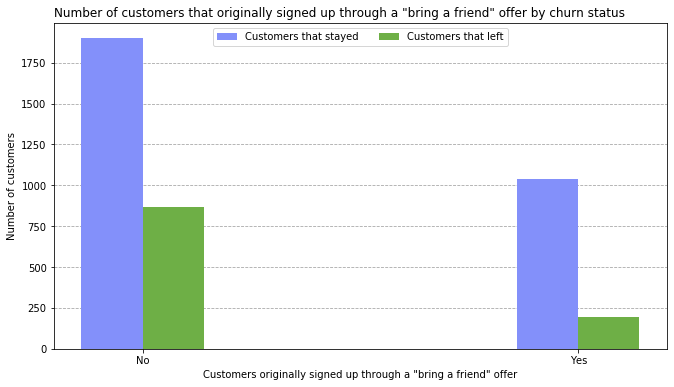

In [25]:
###### Bar chart for 'Partner' by churn status

# rename columns and index of pivot table
pivot_churn_promo.columns = ['Stayed', 'Left']
pivot_churn_promo.index = ['No', 'Yes']

# define figure
fig, ax = plt.subplots(1, figsize=(11, 6))

# numericals
x = np.arange(0, 2)

# plot bars
plt.bar(x - 0.07, pivot_churn_promo['Stayed'], width = 0.14, color = '#8390FA')
plt.bar(x + 0.07, pivot_churn_promo['Left'], width = 0.14, color = '#6EAF46')

# x and y details
plt.ylabel('Number of customers')
plt.xlabel('Customers originally signed up through a "bring a friend" offer')
plt.xticks(x, pivot_churn_promo.index)

# grid lines
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.7)

# title and legend
plt.title('Number of customers that originally signed up through a "bring a friend" offer by churn status', loc ='left')
plt.legend(['Customers that stayed', 'Customers that left'], loc='upper center', ncol = 4)
plt.show()

##### Conclusion

The bar chart shows the number of customers that originally signed up through a "bring a friend" offer by churn status. For both promo cases we have more customers that stayed and for both churn cases the case 'No' has more customers. It is noticeable that there are very few customers that left but originally signed up through a "bring a friend" offer. This is indicated by the mean values which is 0.35 for those who stayed and 0.18 for those who left.

#### Group_visits

In [26]:
# create pivot table
pivot_churn_group = df.pivot_table(index='Group_visits', columns='Churn', values='gender', aggfunc='count')
pivot_churn_group

Churn,0,1
Group_visits,,
0,1575,776
1,1364,285


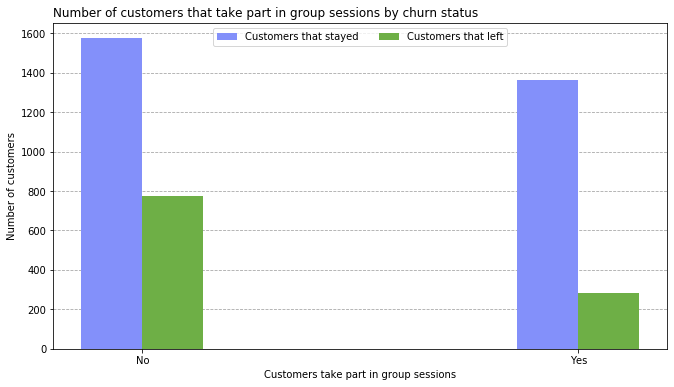

In [27]:
###### Bar chart for 'Group_visits' by churn status

# rename columns and index of pivot table
pivot_churn_group.columns = ['Stayed', 'Left']
pivot_churn_group.index = ['No', 'Yes']

# define figure
fig, ax = plt.subplots(1, figsize=(11, 6))

# numericals
x = np.arange(0, 2)

# plot bars
plt.bar(x - 0.07, pivot_churn_group['Stayed'], width = 0.14, color = '#8390FA')
plt.bar(x + 0.07, pivot_churn_group['Left'], width = 0.14, color = '#6EAF46')

# x and y details
plt.ylabel('Number of customers')
plt.xlabel('Customers take part in group sessions')
plt.xticks(x, pivot_churn_group.index)

# grid lines
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.7)

# title and legend
plt.title('Number of customers that take part in group sessions by churn status', loc ='left')
plt.legend(['Customers that stayed', 'Customers that left'], loc='upper center', ncol = 4)
plt.show()

##### Conclusion

This bar chart shows the number of customers that take part in group sessions by churn status. Compared to the 'Yes' case, the 'No' case shows slightly more customers that stayed but significant more customerst that left. That can be seen in the mean values which is 0.46 for the customers who stayed and 0.27 for the customers who left. 

#### Contract_period

In [28]:
# create pivot table
pivot_churn_contr = df.pivot_table(index='Contract_period', columns='Churn', values='gender', aggfunc='count')

# rename columns and index of pivot table
pivot_churn_contr.columns = ['Stayed', 'Left']
pivot_churn_contr.index = ['1 month', '6 months', '12 months']

pivot_churn_contr

,Stayed,Left
1 month,1273,934
6 months,729,104
12 months,937,23


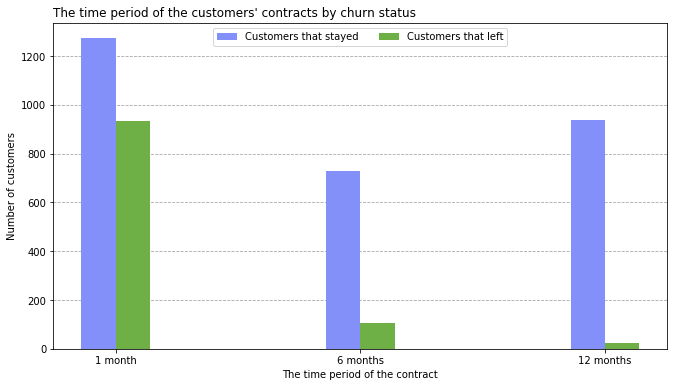

In [29]:
###### Bar chart for 'Contract_period' by churn status

# define figure
fig, ax = plt.subplots(1, figsize=(11, 6))

# numericals
x = np.arange(0, 3)

# plot bars
plt.bar(x - 0.07, pivot_churn_contr['Stayed'], width = 0.14, color = '#8390FA')
plt.bar(x + 0.07, pivot_churn_contr['Left'], width = 0.14, color = '#6EAF46')

# x and y details
plt.ylabel('Number of customers')
plt.xlabel('The time period of the contract')
plt.xticks(x, pivot_churn_contr.index)

# grid lines
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.7)

# title and legend
plt.title("The time period of the customers' contracts by churn status", loc ='left')
plt.legend(['Customers that stayed', 'Customers that left', 'jo'], loc='upper center', ncol = 4)
plt.show()

##### Conclusion

The bar chart shows the number of customers that stayed or left sorted by their defined time period in the contract. We only have three values: 1 month, 6 months and 12 months. Looking at the blue bars we see small but clear differences in the number of customers for different time periods. The differences are much more bigger for the green bars representing the customers that have left; The majority of them only had a contract about one month like the contract was for a testing month. That's why the mean value for the customers who left is 1.73 months which is much smaller than the mean value for the customers who stayed (5.75 months).

#### Age

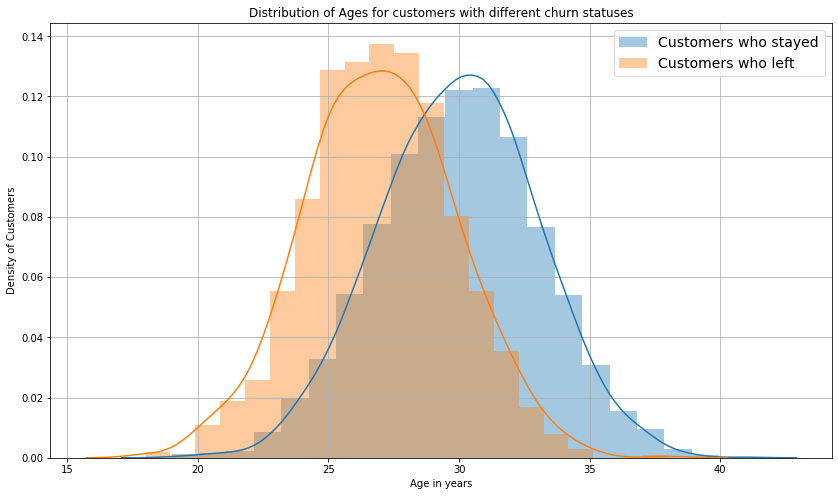

In [30]:
# set figure size
rcParams['figure.figsize'] = 14,8
# plot distribution plots for Ages by churn status
sns.distplot(df[df['Churn'] == 0]['Age'], bins = 21, label = 'Customers who stayed')
sns.distplot(df[df['Churn'] == 1]['Age'], bins = 21, label = 'Customers who left')
plt.title('Distribution of Ages for customers with different churn statuses')
plt.xlabel('Age in years')
plt.ylabel('Density of Customers')
plt.legend(fontsize=14)
plt.grid()
plt.show()

##### Conclusion

The distribution plot shows how the ages of the customers are distributed for customers who stayed (blue graph) and who left (orange graph). It also gives curves that draws a function to the ditsribution. Both distributions are very good approachable with normal distributions as one can see at the curves. We can also see a very clear shift between both distributions, so one can say that in average the customers who left are younger than the customers who stayed (mean age left: 27, mean age stayed: 30). The ages reach values between 18 and 41 years.

#### Month_to_end_contract

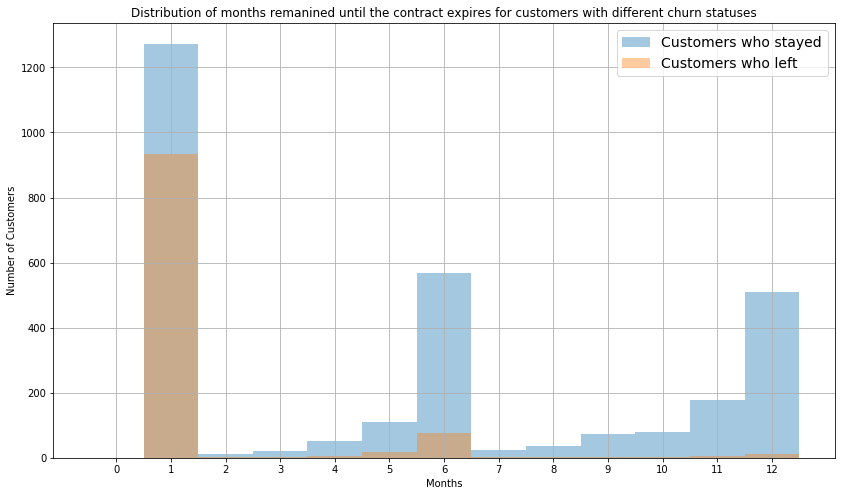

In [31]:
# set figure size
rcParams['figure.figsize'] = 14,8

# set list for bins
bins_list = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5]

# plot distribution plots for months by churn status
sns.distplot(df[df['Churn'] == 0]['Month_to_end_contract'], bins = bins_list, label = 'Customers who stayed', kde=False)
sns.distplot(df[df['Churn'] == 1]['Month_to_end_contract'], bins = bins_list, label = 'Customers who left', kde=False)

plt.title('Distribution of months remanined until the contract expires for customers with different churn statuses')
plt.xlabel('Months')
plt.ylabel('Number of Customers')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.legend(fontsize=14)
plt.grid()
plt.show()

##### Conclusion

The Histogram above shows the number of remained months until the contract expires on the x axis and the appropriate number of customers on the y axis. The histogram has 12 bins according to 12 possible values between 1 and 12 months. For the customers who stayed one can see that the clearly leading months with the most customers are those whose contract has remained 1 month, 6 months and 12 months. It is possible that the most of these users have just started with the contract and don't usually churn after one month. For the customers who stayed also the 1 month and the 6 months values are the leading values. In contrast to the blue bins, the orange bins do have clearly one leader: The most customers who left had one month left on the contract. That's very logical since one can't visit a fitness center the following month when not extending the contract.

#### Lifetime

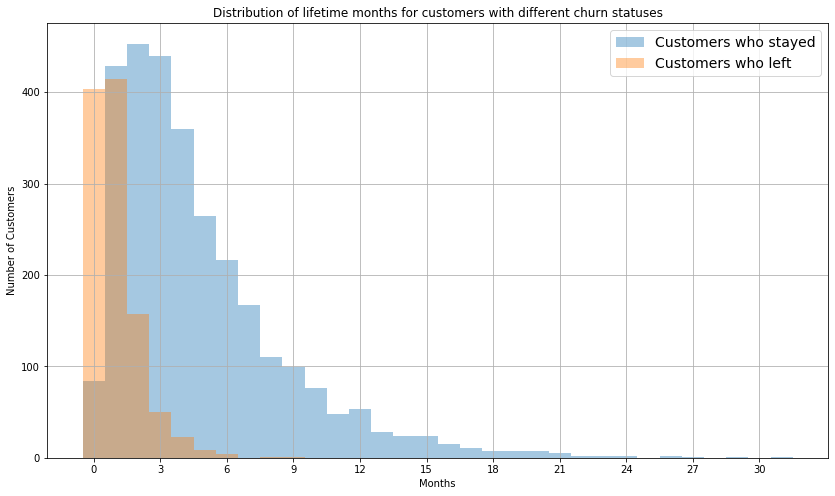

In [32]:
# set figure size
rcParams['figure.figsize'] = 14,8

# set list of bins, one bin for every month between 0 and 31
list_bins = []
for i in range(0, 33):
    number = i - 0.5
    list_bins.append(number)

# plot histogram for lifetime by churn status
sns.distplot(df[df['Churn'] == 0]['Lifetime'], list_bins, label = 'Customers who stayed', kde=False)
sns.distplot(df[df['Churn'] == 1]['Lifetime'], list_bins, label = 'Customers who left', kde=False)

plt.title('Distribution of lifetime months for customers with different churn statuses')
plt.xlabel('Months')
plt.ylabel('Number of Customers')
plt.legend(fontsize=14)
plt.xticks([0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30])
plt.grid()
plt.show()

##### Conclusion

The histograms above show the lifetime of customers who churned and who stayed in months. We have values between 0 months (new customers) and 31 months. Every bin stands for one month. For both groups of customers one can see that the distribution follows approximately an exponential distribution, having a rapid decrease for increasing lifetimes. The highest value is reached at one months for the customers that have left and 2 months for the customers who stayed.

#### additional_charges_total

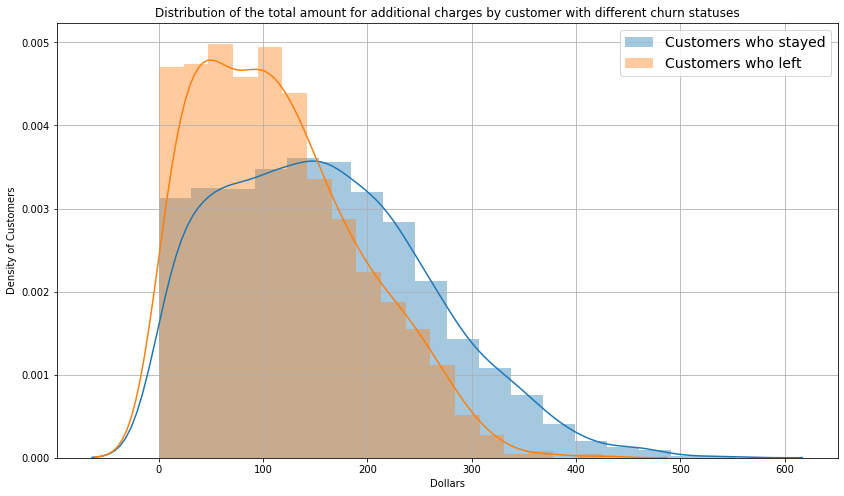

In [33]:
# set figure size
rcParams['figure.figsize'] = 14,8
# plot distribution plots for average additional charges by churn status
sns.distplot(df[df['Churn'] == 0]['additional_charges_total'], bins = 18, label = 'Customers who stayed')
sns.distplot(df[df['Churn'] == 1]['additional_charges_total'], bins = 18, label = 'Customers who left')
plt.title('Distribution of the total amount for additional charges by customer with different churn statuses')
plt.xlabel('Dollars')
plt.ylabel('Density of Customers')
plt.legend(fontsize=14)
plt.grid()
plt.show()

In [34]:
# maxima 
print(df[df['Churn'] == 0]['additional_charges_total'].max())
print(df[df['Churn'] == 1]['additional_charges_total'].max())

552.5907403868798
425.53522047692115


##### Conclusion

The density plots show the the distributions of dollars spent for additional charges split by churn status. The blue histogram (customers who stayed) starts at a high level and increases slightly until it reaches the highest point at around 150 dollars. Then it decreases until it reaches the highest value at 552.59 dollars. The orange histogram (customers who left) also starts with a high distribution and stays at a high level until 150 dollars. For increasing dollars spent the histogram decreases rapidly until it reaches the highest amount spent at 425.54 dollars which is around 127 dollars smaller than the maximum of dollars from the customers who stayed. As one can see the most customers in the group who left are concentrated at smaller charges; this observation explains better the differences in mean values (group 'stayed': 158 dollars, group 'left': 115 dollars).

#### Avg_class_frequency_total

In [35]:
# set list of bins so that every bin covers one quarter of visits
bins_list_visits = [-0.125, 0.125]
for i in range(2, 30):
    number = i / 4 - 0.125
    bins_list_visits.append(number)

bins_list_visits

[-0.125,
 0.125,
 0.375,
 0.625,
 0.875,
 1.125,
 1.375,
 1.625,
 1.875,
 2.125,
 2.375,
 2.625,
 2.875,
 3.125,
 3.375,
 3.625,
 3.875,
 4.125,
 4.375,
 4.625,
 4.875,
 5.125,
 5.375,
 5.625,
 5.875,
 6.125,
 6.375,
 6.625,
 6.875,
 7.125]

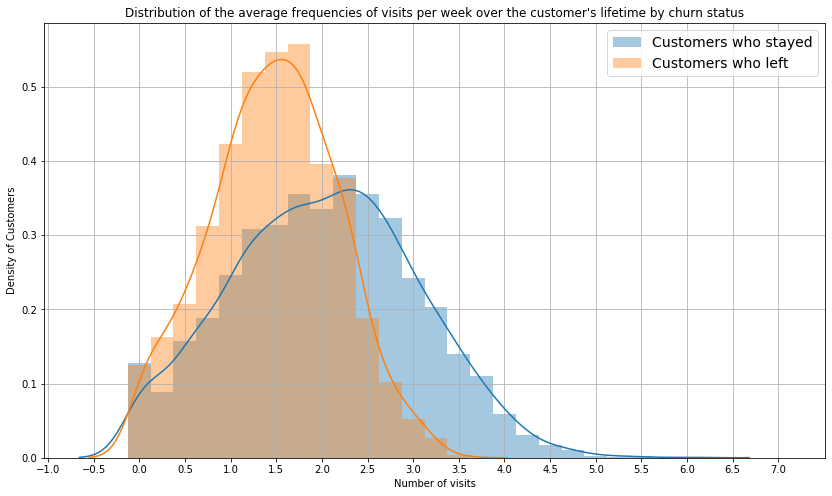

In [36]:
# set figure size
rcParams['figure.figsize'] = 14,8

# plot distribution plots for average frequency of visits per week over the customer's lifetime by churn status
sns.distplot(df[df['Churn'] == 0]['Avg_class_frequency_total'], bins = bins_list_visits, label = 'Customers who stayed')
sns.distplot(df[df['Churn'] == 1]['Avg_class_frequency_total'], bins = bins_list_visits, label = 'Customers who left')
plt.title("Distribution of the average frequencies of visits per week over the customer's lifetime by churn status")
plt.xlabel('Number of visits')
plt.ylabel('Density of Customers')
plt.xticks([-1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7])
plt.legend(fontsize=14)
plt.grid()
plt.show()

##### Conclusion

The density plots show the distributions of the average frequency of visits per week over the customer's lifetime for every churn status. One can see that both plots can be approximated with normal distributions. For the customers who left the variance is bigger than for the other group. As we have already seen in the histograms for additional charges, also here we have a bigger concentration of customers for smaller values in the group of those who left; here the most customers visited between 1 and 2 times per week. In the group of those who stayed there is a broad distribution and for higher values there are more customers in that group. The density graph is near at zero for 4 visits in the group who left and for 6 visits in the group who stayed. 

#### Avg_class_frequency_current_month

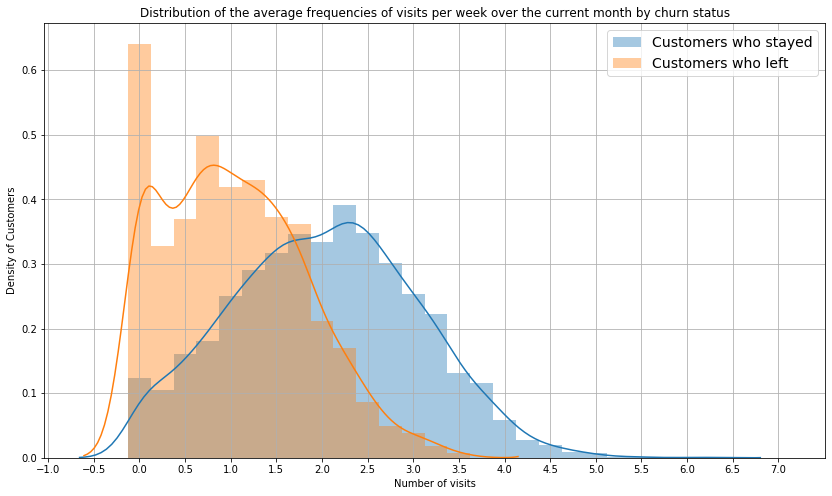

In [37]:
# set figure size
rcParams['figure.figsize'] = 14,8

# plot distribution plots for average frequency of visits per week over the current month by churn status
sns.distplot(df[df['Churn'] == 0]['Avg_class_frequency_current_month'], bins = bins_list_visits, label = 'Customers who stayed')
sns.distplot(df[df['Churn'] == 1]['Avg_class_frequency_current_month'], bins = bins_list_visits, label = 'Customers who left')
plt.title("Distribution of the average frequencies of visits per week over the current month by churn status")
plt.xlabel('Number of visits')
plt.ylabel('Density of Customers')
plt.xticks([-1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7])
plt.legend(fontsize=14)
plt.grid()
plt.show()

##### Conclusion

The density plot shows the distributions of the average frequencies of visits per week over the current month by churn status. For the group who stayed, we can see a broad distribution with the most customers visiting between 1.5 and 2.5 times per week. This distribution is normal distributed and is similar to the distribution we already saw above for the feature 'Avg_class_frequency_total' in the same group. Comparing the distribution for both features in the group who left, we can see differences. One difference is the very high bin around 0 we can see in the plot. There are many customers who barely visited the fitness studios in their lifetime and left the following month. Between 0 and 2 visits, the histogram for the group who left shows many customers for all bins; for increasing visits there is a big descreasing trend until we reach nearly zero density at 4 visits.

<a id="2.5"></a>

### 2.5) Correlation matrix

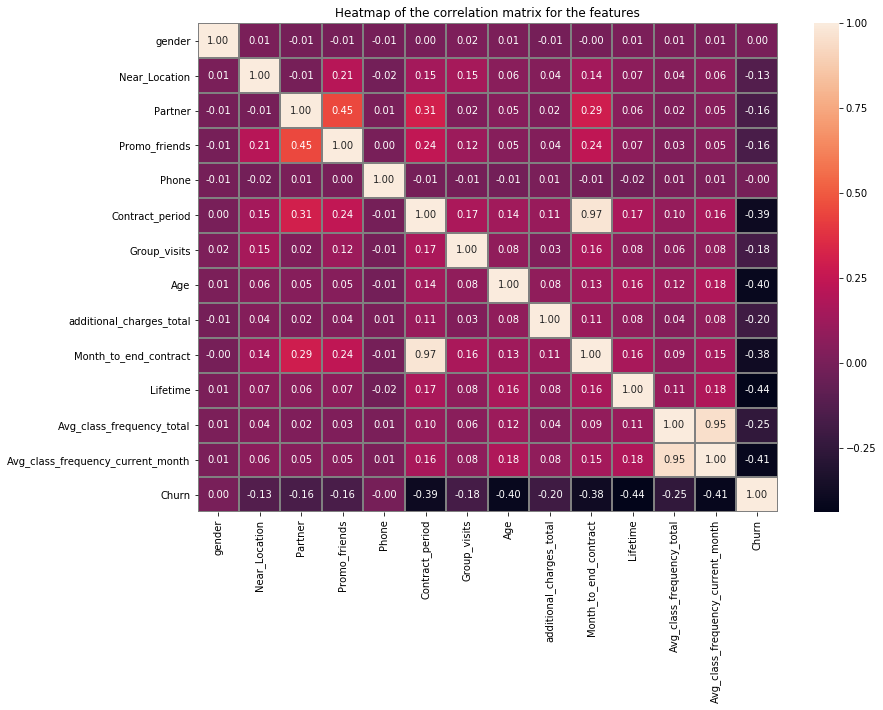

In [38]:
# calculate a correlation matrix
corr_mat = df.corr()
# plot a heatmap for the correlation matrix
plt.figure(figsize=(13, 9))
plt.title('Heatmap of the correlation matrix for the features')
sns.heatmap(
    corr_mat,
    annot=True,
    fmt='.2f',
    linewidths=1,
    linecolor='grey')
plt.show()

#### Conclusion

Looking at the heatmap displaying the correlation coefficients between all features, one can see in generall that there are many feature pairs with nearly no correlation (coefficients smaller than 0.2). An outstanding coefficient of 0.45 is between the features 'Partner' and 'Promo_friends'. It's not so surprising that employees working in a partner company are advertising each other in order to get discounts for promo actions. Another high coefficient of 0.97 is given for the pair 'Month_to_end_contract' and 'Contract_period'. That's also very logical: The longer the period in a contract the higher the chance that the end of the contract has takes more months. We also saw for both features very high values for one month. A very big coefficient of 0.95 is given for the features 'Avg_class_frequency_total' and 'Avg_class_frequency_curent_month'. That means the more times per week a customer visited the gym in the lifetime the more times the customer visits it in the current month; that's also not surprising, but the correlation is very high. <br> <br>
Looking especially at the target feature 'Churn' we can see many negative correlations. The highest correlations are given for the features 'Lifetime' (-0.44), 'Avg_class_frequency_current_month' (-0.41), 'Age' (-0.40), 'Contract_period' (-0.39) and 'Month_to_end_contract' (-0.38). Now we see which features of a customer have the biggest impact on its churn status for the following month (in terms of correlation, not in terms of causality).

<a id="3"></a>

## 3) Build a Model to Predict Customer Churn

I build a binary classification model for customers where the target feature is 'Churn'. I will evaluate the metrics accuracy, precision, and recall for two modells and use them to compare the models. We will answer the question: Which model gave better results?

In [39]:
# divide the data into features (the X matrix) and a target variable (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

In [40]:
# divide the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [41]:
# create a StandardScaler object
scaler = StandardScaler()
# apply standardization to the train set
X_train_st = scaler.fit_transform(X_train)
# apply standardization to the feature matrix for the test set
X_test_st = scaler.transform(X_test)

In [42]:
# define a function that takes the model and data as input and outputs the metrics to evaluate:
# accuracy, precision, and recall

def make_prediction(mod, X_train, y_train, X_test, y_test, title):
    model = mod
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(title)
    print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.3f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.3f}'.format(recall_score(y_test, y_pred)))

In [43]:
# define the models

forest_model = RandomForestClassifier(n_estimators=100, random_state=0)
log_reg_model = LogisticRegression(random_state=0)

In [44]:
# output metrics for each model

make_prediction(mod=forest_model, \
                X_train=X_train_st, y_train=y_train, X_test=X_test_st, y_test=y_test, \
               title="Metrics for the model 'Random Forest Classifier':")
print()   
make_prediction(mod=log_reg_model, \
                X_train=X_train_st, y_train=y_train, X_test=X_test_st, y_test=y_test, \
               title="Metrics for the model 'Logistic Regression':")

Metrics for the model 'Random Forest Classifier':
Accuracy: 0.915
Precision: 0.839
Recall: 0.813

Metrics for the model 'Logistic Regression':
Accuracy: 0.922
Precision: 0.854
Recall: 0.828


In [45]:
print("Total number of customers:", len(df))
print("Total number of customers that stayed:", len(df[df['Churn'] == 0]))
print("Total number of customers that left:", len(df[df['Churn'] == 1]))
print()
print("{:.1%} of all customers left.".format(len(df[df['Churn'] == 1]) / len(df)))

Total number of customers: 4000
Total number of customers that stayed: 2939
Total number of customers that left: 1061

26.5% of all customers left.


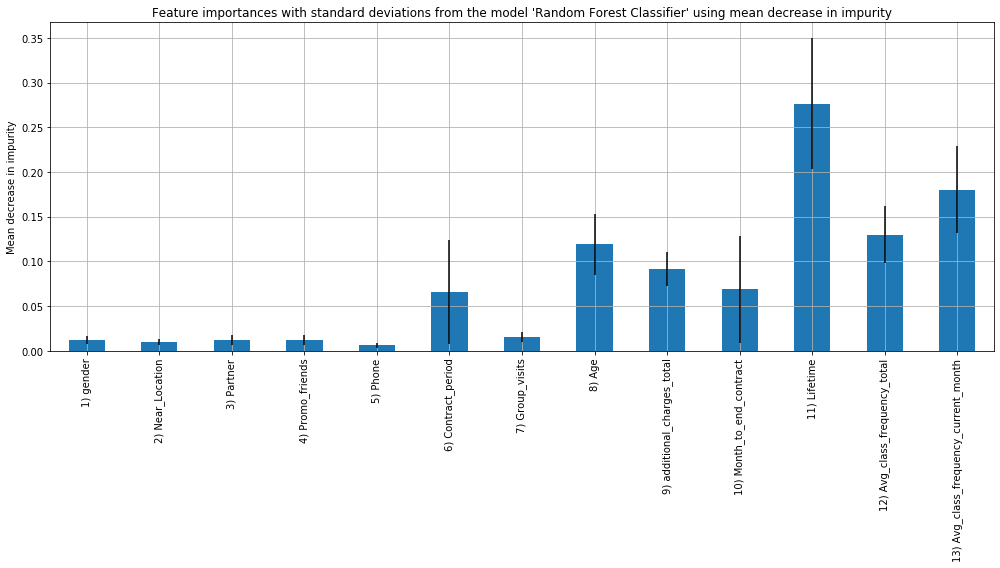

In [46]:
# feature importances from the model 'Random Forest Classifier' based on mean decrease in impurity

# get mean and standard deviation of accumulation of the impurity decrease within each tree
importances = forest_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_model.estimators_], axis=0)

# list of feature names
feature_names = []
for i in range(len(X.columns)):
    feature_names.append("{}) {}".format(i+1, X.columns[i]))

# create series for graph
forest_importances = pd.Series(importances, index=feature_names)

# plot graph
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances with standard deviations from the model 'Random Forest Classifier' using mean decrease in impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.grid()
plt.show()

### Conclusion

The graph above shows the feature importances based on the model 'Random Forest Classifier' with the method of mean decrease in impurity. As expected, the first five features and the 7th feature in the graph have small means below 0.03; based on absolute values of coefficients (I always use for this conclusion), these are features with correlation coefficients below 0.2. The coefficients for the features 9, 12 and 13 are 0.2 for 9, 0.25 for 12 and 0.41 for 13. As features 9 and 12 have similar coefficients the bars in the graphs still show different means for these two features. It's important to mention that impurity-based feature importances can be misleading for high cardinality features; the three features 9, 12 and 13 have exactly this issue, so one can't really rely strongly on the means in the graph for these three features. The correlation coefficient for feature 10 is 0.38 and for feature 11 is 0.44. Even though both values are similar the means in the graph show big differences: The standard deviation for feature 10 is very huge compared to the one of feature 11. When reminding of the distributions, feature 10 ('Month_to_end_contract') had distributions that were focused strongly on three values while feature 11 ('Lifetime') had recognizable distributions that differed very much in terms of churn status. That means based on the model 'Random Forest Classifier' we can say the feature 'Lifetime' has the highest importance.

Metrics for the model 'Random Forest Classifier':
- Accuracy: 0.915
- Precision: 0.839
- Recall: 0.813

Metrics for the model 'Logistic Regression':
- Accuracy: 0.922
- Precision: 0.854
- Recall: 0.828

For both models the accuracy metric shows values above 90%. The balance between customers who left and customers who stayed is 26.5 to 73.5, so the metric accuracy show significant higher values than the 73.5% value from the balance. For the precision metric, both models show values above 80%. The same applies to the recall metric. Comparing the numbers between both models, one can see slightly higher values for the model 'Logistic Regression' in every of the three metrics. For the logistic regression method that means it found more accurate predictions among all predictions, found a higher share of true class 1 predictions and found a higher share of real class 1 objects compared to the random forest classifier method. Since the goal is to predict the probability of churn for the upcoming month for each customer, the higher values in the precision and the recall metric for the logistic regression method show that this model gave better results than the random forest classifier model.

<a id="4"></a>

## 4) Create Customer Clusters

<a id="4.1"></a>

### 4.1) Estimation of the number of clusters with a dendrogram

In [48]:
# Set aside the column with data on churn
df_cluster = df.drop('Churn', axis=1)

# standardize the data
scaler = StandardScaler()
df_cluster_st = scaler.fit_transform(df_cluster)

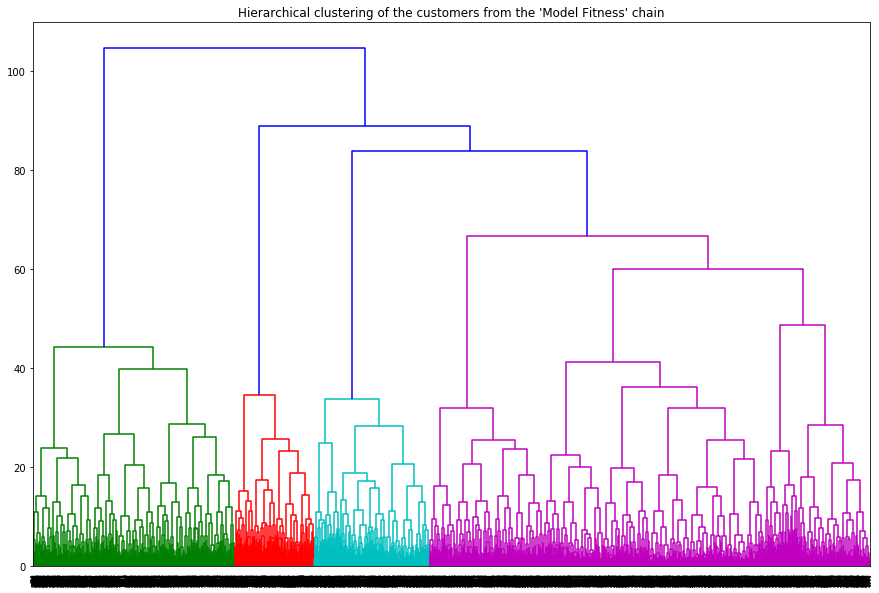

In [49]:
# build a matrix of distances based on the standardized feature matrix
# the plot becomes more representative if we pass 'ward' to the method parameter
linked = linkage(df_cluster_st, method = 'ward')
# create dendrogram
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title("Hierarchical clustering of the customers from the 'Model Fitness' chain")
plt.show()

The plot above is a dendrogram that shows the hierarchical clustering of the customers. Since we can identify 4 different colors below, the optimal number of clusters is calculated with 4.

#### Conclusion

We can use dendrograms to visually estimate the necessary number of clusters. The suggested optimal number of clusters corresponds to the number of different colors on the plot; in our case we have 4 colors, so 4 cluster is optimal. The task in for this project corresponds to 5 clusters, so we will continue assuming 5 clusters.

<a id="4.2"></a>

### 4.2) K-means algorithm and the mean feature values for clusters

In [50]:
# define the k_means model with 5 clusters
km_model = KMeans(n_clusters=5, random_state=42)

# predict customer clusters
labels = km_model.fit_predict(df_cluster_st)

# store cluster labels in the field of our dataset
df_cluster['cluster_km'] = labels
 
# get the statistics of the mean feature values per cluster
gym_cluster_mean = df_cluster.groupby(['cluster_km']).mean().reset_index()

gym_cluster_mean

,cluster_km,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,0,0.502370,0.949447,0.829384,0.998420,1.0,3.097946,0.448657,29.104265,141.774331,2.887836,3.772512,1.770536,1.669581
1,1,0.554556,0.849269,0.263217,0.052868,1.0,2.606299,0.436445,30.008999,159.774265,2.419573,4.780652,2.745505,2.733173
2,2,0.499422,0.937572,0.737572,0.478613,1.0,11.854335,0.546821,29.905202,163.509804,10.812717,4.677457,2.006405,1.998179
3,3,0.485738,0.718011,0.299919,0.018745,1.0,1.914425,0.276284,28.083945,129.496414,1.821516,2.195599,1.225192,0.967967
4,4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967


#### Conclusion

I used the K-means algorithm and found the mean feature values for every cluster. The following characteristics are given for every cluster:

- Cluster 0: High mean values for 'Near_Location' (0.95), 'Partner' (0.83), 'Promo_friends' (0.99) <br> <br>
- Cluster 1: High mean values for 'additional_charges_total' (159.8 dollars), 'Lifetime' (4.8 months), 'Avg_class_frequency_total' (2.7 visits), 'Avg_class_frequency_current_month' (2.7 visits) <br> <br>
- Cluster 2: High mean values for  'Near_Location' (0.94), 'Partner' (0.74), 'Contract_period' (11.85 months), additional_charges_total' (163.5 dollars), 'Month_to_end_contract' (10.81 months), 'Lifetime' (4.7 months) <br> <br>
- Cluster 3: Low mean values for 'Partner' (0.3), 'Promo_friends' (0.02), 'Contract_period' (1.91 months), 'Group_visits' (0.28), 'additional_charges_total' (129.5 dollars), 'Month_to_end_contract' (1.82 months), 'Lifetime' (2.2 months), 'Avg_class_frequency_total' (1.2 visits), 'Avg_class_frequency_current_month' (0.97 visits) <br> <br>
- Cluster 4: Low mean values for 'Phone' (0.0); the other features have average means compared to the other clusters

Cluster 0 seems to consist of many employees from partner companies that live near the gym and came through a promotion from a friend. Cluster 1 consists of many customers that have a long lifetime in the gym, visit the gym very often and spend more money there. Cluster 2 consists of many customers that live near the gym and are working in a partner company; they have longer contract time period and they spend more for additional charges; they also have a long lifetime. Cluster 3 consists of customers that have contracts with short time periods, barely visit group sessions, spend less money, have a short lifetime and visit the gym rarely. Cluster 4 consists of the average customers that don't belong to the other groups; they don't often provide their phone number to the gym. <br> <br> The most noticeable aspects are cluster 0 having three features with very high means that match together well and cluster 2 having very high time periods in the contracts and many customers living near the gym.

<a id="4.3"></a>

### 4.3) Distributions of features by cluster

In [51]:
# number of customers for every cluster
print(len(df_cluster[df_cluster['cluster_km'] == 0]))
print(len(df_cluster[df_cluster['cluster_km'] == 1]))
print(len(df_cluster[df_cluster['cluster_km'] == 2]))
print(len(df_cluster[df_cluster['cluster_km'] == 3]))
print(len(df_cluster[df_cluster['cluster_km'] == 4]))

633
889
865
1227
386


For every cluster we have enough customers to plot appropriate distribution plots.

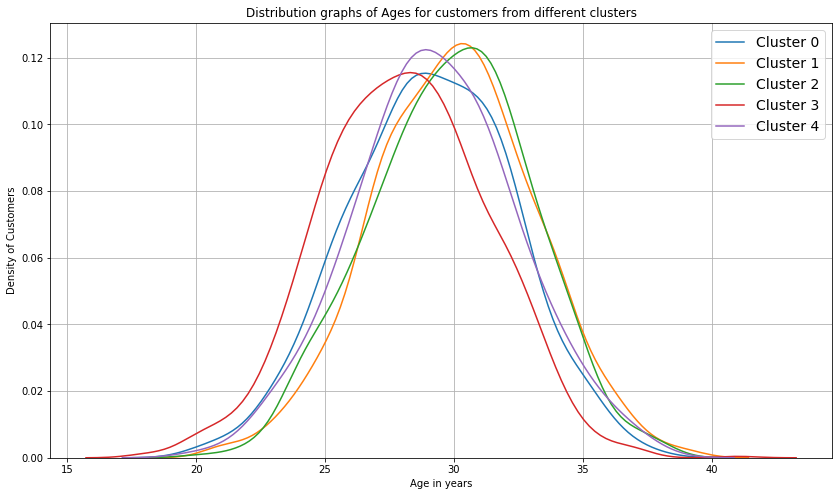

In [52]:
# set figure size
rcParams['figure.figsize'] = 14,8
# plot distribution plots for Ages by cluster
sns.distplot(df_cluster[df_cluster['cluster_km'] == 0]['Age'], label = 'Cluster 0', hist = False)
sns.distplot(df_cluster[df_cluster['cluster_km'] == 1]['Age'], label = 'Cluster 1', hist = False)
sns.distplot(df_cluster[df_cluster['cluster_km'] == 2]['Age'], label = 'Cluster 2', hist = False)
sns.distplot(df_cluster[df_cluster['cluster_km'] == 3]['Age'], label = 'Cluster 3', hist = False)
sns.distplot(df_cluster[df_cluster['cluster_km'] == 4]['Age'], label = 'Cluster 4', hist = False)
plt.title('Distribution graphs of Ages for customers from different clusters')
plt.xlabel('Age in years')
plt.ylabel('Density of Customers')
plt.legend(fontsize=14)
plt.grid()
plt.show()

The density plot shows a slightly shift for the normal distribution of cluster 3 compared to those from the other clusters. Overall, for ages there can't be seen any significant differences between the clusters.

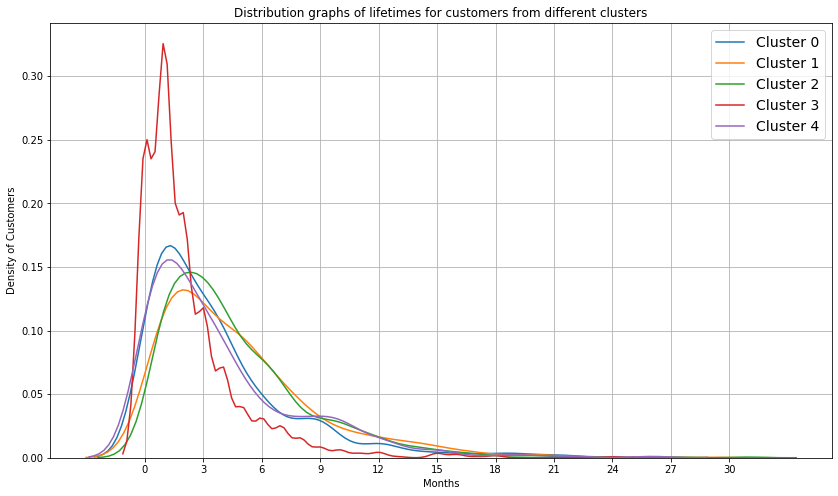

In [53]:
# set figure size
rcParams['figure.figsize'] = 14,8

# plot distribution plots for lifetimes by cluster
sns.distplot(df_cluster[df_cluster['cluster_km'] == 0]['Lifetime'], label = 'Cluster 0', hist = False)
sns.distplot(df_cluster[df_cluster['cluster_km'] == 1]['Lifetime'], label = 'Cluster 1', hist = False)
sns.distplot(df_cluster[df_cluster['cluster_km'] == 2]['Lifetime'], label = 'Cluster 2', hist = False)
sns.distplot(df_cluster[df_cluster['cluster_km'] == 3]['Lifetime'], label = 'Cluster 3', hist = False)
sns.distplot(df_cluster[df_cluster['cluster_km'] == 4]['Lifetime'], label = 'Cluster 4', hist = False)
plt.title('Distribution graphs of lifetimes for customers from different clusters')
plt.xlabel('Months')
plt.ylabel('Density of Customers')
plt.legend(fontsize=14)
plt.xticks([0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30])
plt.grid()
plt.show()

The density plot shows a very different distribution for cluster 3 compared to the other clusters in lifetime months. For cluster 3, the most customers are concentrated for low month values as one can see at the high red peak for cluster 3.

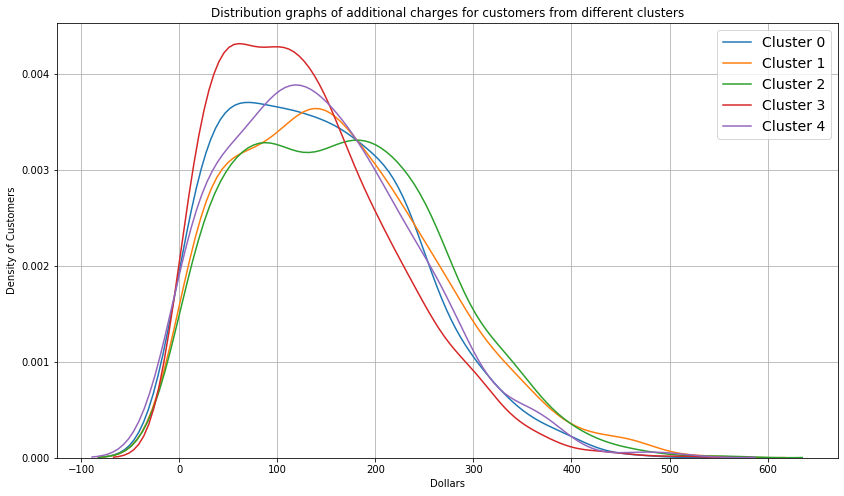

In [54]:
# set figure size
rcParams['figure.figsize'] = 14,8
# plot distribution plots for charges by cluster
sns.distplot(df_cluster[df_cluster['cluster_km'] == 0]['additional_charges_total'], label = 'Cluster 0', hist = False)
sns.distplot(df_cluster[df_cluster['cluster_km'] == 1]['additional_charges_total'], label = 'Cluster 1', hist = False)
sns.distplot(df_cluster[df_cluster['cluster_km'] == 2]['additional_charges_total'], label = 'Cluster 2', hist = False)
sns.distplot(df_cluster[df_cluster['cluster_km'] == 3]['additional_charges_total'], label = 'Cluster 3', hist = False)
sns.distplot(df_cluster[df_cluster['cluster_km'] == 4]['additional_charges_total'], label = 'Cluster 4', hist = False)
plt.title('Distribution graphs of additional charges for customers from different clusters')
plt.xlabel('Dollars')
plt.ylabel('Density of Customers')
plt.legend(fontsize=14)
plt.grid()
plt.show()

The density plot showing the money spent for additional charges by cluster displays similar distributions for all clusters. When looking more in detail, for cluster 3 one can see that slightly more customers are concentrated at less dollars spent. The plot for cluster 3 slightly stands out from the ones of the other clusters.

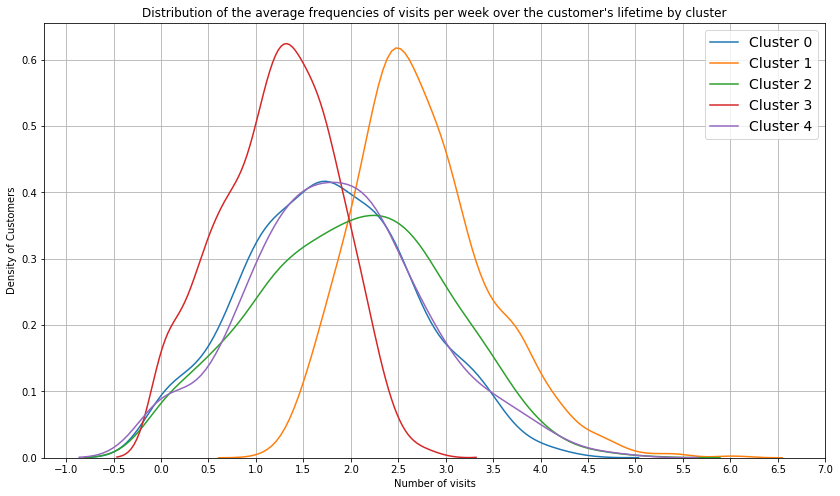

In [55]:
# set figure size
rcParams['figure.figsize'] = 14,8
# plot distribution plots for the average frequency of visits per week over the customer's lifetime by cluster
sns.distplot(df_cluster[df_cluster['cluster_km'] == 0]['Avg_class_frequency_total'], label = 'Cluster 0', hist = False)
sns.distplot(df_cluster[df_cluster['cluster_km'] == 1]['Avg_class_frequency_total'], label = 'Cluster 1', hist = False)
sns.distplot(df_cluster[df_cluster['cluster_km'] == 2]['Avg_class_frequency_total'], label = 'Cluster 2', hist = False)
sns.distplot(df_cluster[df_cluster['cluster_km'] == 3]['Avg_class_frequency_total'], label = 'Cluster 3', hist = False)
sns.distplot(df_cluster[df_cluster['cluster_km'] == 4]['Avg_class_frequency_total'], label = 'Cluster 4', hist = False)
plt.title("Distribution of the average frequencies of visits per week over the customer's lifetime by cluster")
plt.xlabel('Number of visits')
plt.ylabel('Density of Customers')
plt.xticks([-1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7])
plt.legend(fontsize=14)
plt.grid()
plt.show()

The distribution plot shows the average frequencies of visits per week over the customer's lifetime by cluster. The distributions are normal distributed and for cluster 1 and 3 one can see huge differences in distribution: Cluster 3 is concentrated for smaller number of visits whereas cluster 1 is concentrated for higher number of visits. The highest point of these two distributions are clearly distinguishable.

#### Conclusion

Most often the distributions from cluster 3 are noticeable and different from those of the other clusters. For the number of visits per week within the lifetime also cluster 1 showed significant differences in its distribution. Overall, the number of visits per week shows the biggest differences in distribution between the clusters.

<a id="4.4"></a>

### 4.4) Churn rate for each cluster

In [56]:
# add the churn column
df_cluster['Churn'] = df['Churn']

In [57]:
# groupby cluster, the mean values for churn correspond to the churn rate of the cluster
df_cluster.groupby(['cluster_km']).mean().reset_index()[['cluster_km', 'Churn']]

,cluster_km,Churn
0,0,0.246445
1,1,0.089989
2,2,0.021965
3,3,0.572942
4,4,0.266839


#### Conclusion

Churn rates:

- Cluster 0: 25%
- Cluster 1: 9%
- Cluster 2: 2%
- Cluster 3: 57%
- Cluster 4: 27%

As one can see at the values the churn rate varies from cluster to cluster. One can notice that cluster 3 has the highest churn rate and also the the distributions that are different from those of other clusters as we saw in the previous section. The value of 57% is significant higher than the other values. The lowest values lower than 10% have cluster 1 and 2. Also cluster 1 showed a different distribution for the feature 'Avg_class_frequency_total' where the most customers are concentrated for higher number of visits per week. For these two cluster we also had the highest mean lifetimes of around 4.7 months. That means that lifetime and the number of visits per week over the lifetime are good indicators for churn.

<a id="5"></a>

## 5) Overall Conclusion and Recommendations

The gym chain 'Model Fitness' has digitized a number of its customer profiles and provided data on churn for a given month and information on the month preceding it. The data consists of 14 featuers for 4000 customers. We divided the customers into two groups: Those who stayed and those who left in the given month. In general, the distributions showed that for some features the distributions for these two groups have been different; for example for the feature lifetime or the number of visits per week over the customer's lifetime. Looking at correlations between features and churn, the biggest correlations we found are only moderate; the biggest was found for churn and lifetime with a correlation coefficient of -0.44. <br> <br> We splitted the data in the ratio 80/20 in order to use random 80% of the data as training for the machine learning models Random Forest Classifier and Logistic Regression. The 20% of data left have been used to predict the churn status. Comparing the results by looking at the metrics accuracy, precision, and recall we found out that both models were good, but the Logistic Regression had slightly better results. When we looked at the feature importances from the Model 'Random Forest Classifier', we found out that the feature 'Lifetime' has significantly the highest mean decrease in impurity resp. is the most important one based on that model. <br> <br> The third part of the project consisted of creating customer clusters. After setting the target feature 'churn' aside I created a dendrogram that is built of a matrix of distances. The dendrogram showed 4 clusters, but in this project we use 5 clusters. After that we used the K-means algorithm and calculated the mean values for the features by cluster. Cluster 2 has often high time periods in the contracts and many customers live near the gym. Cluster 2 is also the group with the smallest churn rate of 2%. Also cluster 1 has a very small churn rate of 9%. For cluster 1 when we looked at the distributions of featuers by cluster, we found that the customers are in average significantly more often in the gym per week over the lifetime. For these two clusters with very low churn rates (cluster 1 and 2) we also found significantly the highest mean values of lifetime which is given by 4.7 months approximately; the lifetime feature was also the one with the highest correlation coefficient with the feature 'churn', so lifetime shows impact to churn rates in terms of correlation and also in terms of grouping the customers. We also look at the cluster with the highest churn rate: Cluster 3 with 57%. Cluster 3 showed significant many customers with less visits per week per lifetime, significant shorter lifetimes and more customers that spent less money for additional charges. These features lead to a high probability that the customer leaves the gym in the following month. <br> <br>
I recommend to not only focus on new customers but also add and maintain services for customers that are already longer in the gym since a longer lifetime correlates with churn rates and since the groups with longer lifetimes showed significant less churn rates; a trainer could ask if a training plan that was given to a new customers one month ago could be changed or reworked. <br> I also recommend that a visit becomes as comfortable for the customer as possible since groups differenciate in average visits per week over the lifetime corresponding to their churn rate. One could for example find out which background music is comfortable for the most customers and which styling of the gym attracts the most customers. <br> The group with the highest churn rate also has significant more customers that spent less money for additional charges. I recommend to encourage the customers to spent more for additional services, for example with a vending automat selling small sports food products or drink flatrates for a certain amount of money per month.